In [ ]:
# Related Pages : 
#  1 - GMM http://docs.pymc.io/notebooks/gaussian_mixture_model.html 
#  2 - GMM with ADVI http://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html
#  3 - Possible GMM Bugs: https://gist.github.com/AustinRochford/e45b7e5f7d18d77f391d3373801e4c9a 
#      Possible GMM Bugs: https://gist.github.com/AustinRochford/41109579c8be23a10e2cd167209dbe25

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pymc3 as pm
import theano.tensor as tt

In [2]:
SEED = 12345
rng = np.random.RandomState(SEED)

In [9]:
def observed_data(ndim,k,nsamples):
    """  create observed data 
       ndim : int, dimension 
       k : int, number of clusters 
       nsamples: int, total number of points
    """
    # means 
    ms = np.random.multivariate_normal(np.zeros(ndim),np.eye(ndim)*5,k)
    
    # Weights: equal for each cluster
    ps = np.ones(k)/k

    zs = np.array([rng.multinomial(1, ps) for _ in range(nsamples)]).T
    xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(ndim), 
       size=nsamples) for z, m in zip(zs, ms)]
    data = np.sum(np.dstack(xs), axis=2)
   
    return data,ms

In [10]:
colors ='bgrcmykw'
def plot_data2d(datas):
    """ plotting 2d data set with different colors"""
    fig =plt.figure(figsize=(5, 5))
    ltext = set()
    limg = set()
    for i in range(len(datas)): 
        data = datas[i]
        ds = plt.scatter(data[:, 0], data[:, 1], alpha=1, c=colors[i+1])
    fig.suptitle('Generated Data ', fontsize=20)
    plt.xlabel('Axis 1', fontsize=18)
    plt.ylabel('Axis 2', fontsize=18)    

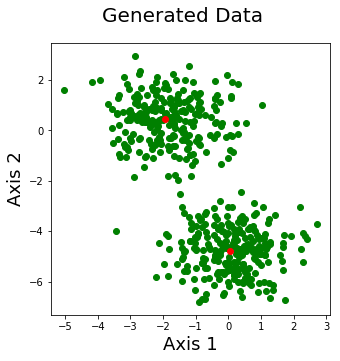

In [11]:
# example data in 2d
ndim = 2 
nsamples = 500 
k = 2 
data,ms = observed_data(ndim,k,nsamples)
plot_data2d((data,ms))

# Define model on 2d Dataset 
Example from GMM with ADVI Tutorial PyMC3

In [12]:
# From GMM with ADVI Tutorial PyMC3

# The log likelihood of the total probability is calculated 
# using logsumexp 
from pymc3.math import logsumexp 
from theano.tensor.nlinalg import det

# loglikelihood of normal distribution 
def logp_normal(mu,tau,value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu 
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# log likelihood of GMM 
def logp_gmix(mus,pi,tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :nsamples], axis=0))
    
    return logp_ 

In [13]:
# Define model 
nsamples = 5000
with pm.Model() as model2d:
    mus = [pm.MvNormal('mu_%d'%i,
                      mu=pm.floatX(np.zeros(ndim)),
                      tau=pm.floatX(0.1*np.eye(ndim)),
                      shape=(ndim,))
          for i in range(k)]
    pi = pm.Dirichlet('pi',a=pm.floatX(0.1*np.ones(k)),shape=(k,))
    xs = pm.DensityDist('x',logp_gmix(mus,pi,np.eye(ndim)),observed=data)

In [14]:
# Sample 
with model2d:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step, start=start)

logp = -4,682.2, ||grad|| = 833.01: 100%|██████████| 4/4 [00:00<00:00, 690.85it/s]
100%|██████████| 1500/1500 [00:01<00:00, 784.22it/s]


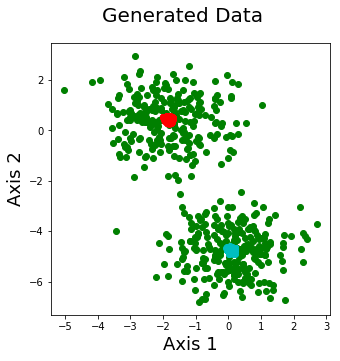

In [15]:
# plot generated values for 2d  
mu_0,mu_1 = trace.get_values('mu_0'),trace.get_values('mu_1')
plot_data2d((data,mu_0[-500:,:],mu_1[-500:,:]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fb8f689e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1fb8ee44a8>]], dtype=object)

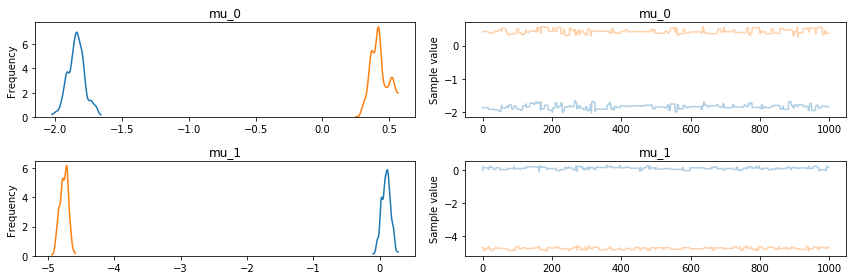

In [16]:
pm.plots.traceplot(trace,['mu_0','mu_1'])

# High Dimensional Data

In [23]:
ndim = 50 
nsamples = 500
k = 2 
# data in 50d
data,ms = observed_data(ndim,k,nsamples)

# With Metropolis 

In [32]:
nsamples = 5000
with pm.Model() as model_metropolis:
    # run model with Metropolis
    mus = [pm.MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(ndim)),
                    tau=pm.floatX(0.1 * np.eye(ndim)),
                    shape=(ndim,))
           for i in range(k)]
    pi = pm.Dirichlet('pi', a=pm.floatX(0.1 * np.ones(k)), shape=(k,))
    xs = pm.DensityDist('x', logp_gmix(mus, pi, np.eye(ndim)), observed=data)

    step = pm.Metropolis()
    trace = pm.sample(nsamples, step=step,tune=1000)    

100%|██████████| 6000/6000 [00:18<00:00, 331.80it/s]


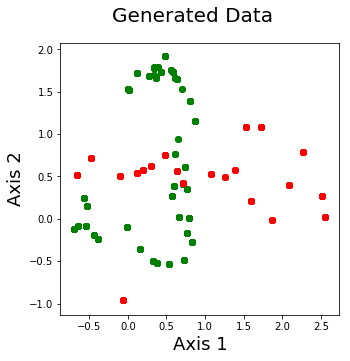

In [34]:
mu0 = pca.fit_transform(trace.get_values('mu_0'))
mu1 = pca.fit_transform(trace.get_values('mu_1'))
# the posterior of component means and weights 
plot_data2d((mu0,mu1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fc0049630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1fb9ab1940>]], dtype=object)

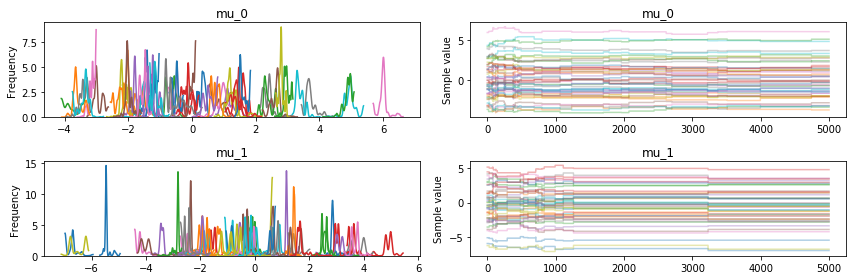

In [36]:
pm.plots.traceplot(trace,['mu_0','mu_1'])

# With NUTS 

In [37]:
n_samples = 5000
with pm.Model() as model_nuts:
    # run model with Metropolis
    mus = [pm.MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(ndim)),
                    tau=pm.floatX(0.1 * np.eye(ndim)),
                    shape=(ndim,))
           for i in range(k)]
    pi = pm.Dirichlet('pi', a=pm.floatX(0.1 * np.ones(k)), shape=(k,))
    xs = pm.DensityDist('x', logp_gmix(mus, pi, np.eye(ndim)), observed=data)

    step = pm.NUTS()
    trace = pm.sample(nsamples, step=step,tune=1000)    

100%|█████████▉| 5998/6000 [02:31<00:00, 39.47it/s]/home/usernobody/miniconda2/envs/pystan/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1475 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [02:32<00:00, 39.46it/s]


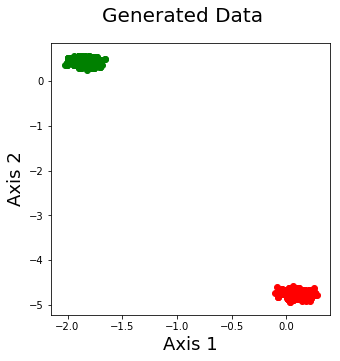

In [40]:
mu0 = pca.fit_transform(trace.get_values('mu_0'))
mu1 = pca.fit_transform(trace.get_values('mu_1'))
# the posterior of component means and weights 
# plot_data2d((data2d,mu_0[-500:,:],mu_1[-500:,:]))
plot_data2d((mu_0[-1000:,:],mu_1[-1000:,:]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fb0659c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1fb0eaaf98>]], dtype=object)

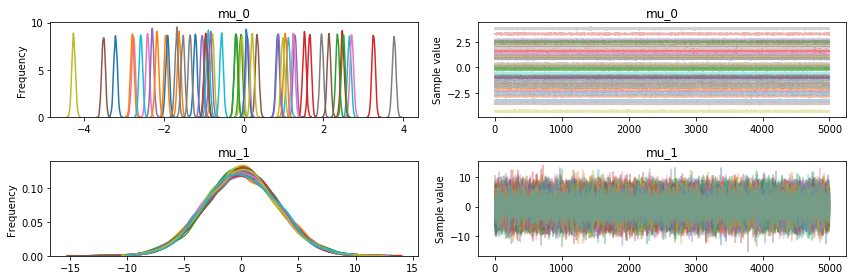

In [41]:
pm.plots.traceplot(trace,['mu_0','mu_1'])

In [ ]:
plt.plot()